In [5]:
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/45466947/include-output-from-matplotlib-notebook-backend-as-svg-in-ipynb
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tempfile
import subprocess
import os
import json
from types import SimpleNamespace
from statistics import harmonic_mean

CWD = os.getcwd()
NS_PER_US = 1e3
print(f'Running in {CWD}.. this should be the project root folder!')

Running in /Users/rongshuge/Desktop/homo/groupoid_model_in_lean4/bench.. this should be the project root folder!


In [ ]:
def measure(samplerMod, sampleCmd, constNm, dataFile):
  with tempfile.NamedTemporaryFile(mode='w', suffix='.lean', encoding='utf-8') as f:
    f.write(f'''
      import bench.samplers.{samplerMod}
      import bench.measure
      set_option maxHeartbeats 0
      {sampleCmd}
      #measure {constNm} "{dataFile}" 0
    ''')
    f.flush()
    subprocess.run(["lake", "lean", f.name], cwd=CWD)

In [39]:
N = 99
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('pair', f'#sample_pairs {N}', f'benchDef_pair_{i}', 'bench/2025_09_05_times_pair_cache.ndjson')
  measure('prod', f'#sample_prods {N}', f'benchDef_prod_{i}', 'bench/2025_09_05_times_prod_cache.ndjson')
  measure('id', f'#sample_ids {N}', f'benchDef_id_{i}', 'bench/2025_09_05_times_id_cache.ndjson')
  measure('fn', f'#sample_fns {N}', f'benchDef_fn_{i}', 'bench/2025_09_05_times_fn_cache.ndjson')

In [83]:
N = 499
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('id', f'#sample_ids {N}', f'benchDef_id_{i}', 'bench/2025_09_05_times_id_cache.ndjson')

In [ ]:
data = {}
with open('bench/2025_09_05_times_pair_cache.ndjson', 'r') as f:
  for line in f:
    obj = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
    # Prefers latest data when seeing multiple entries for the same definition
    data[obj.name] = obj

In [74]:
xs = [ ob.sz_val for ob in data.values() ]
ys = [ ob.t_kernel for ob in data.values() ]
rys = [ ob.t_rkernel_shared for ob in data.values() ]
(xs, ys, rs) = zip(*sorted(zip(xs, ys, rys)))

print(f'Kernel (deep) / kernel: {harmonic_mean([ry/y for (ry, y) in zip(rys, ys)])}')

Kernel (deep) / kernel: 3506.5719189319248


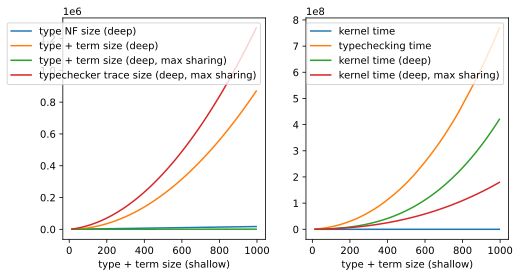

In [75]:
xs = [ ob.sz_val + ob.sz_tp for ob in data.values() ]
ys = [ ob.sz_deep_val + ob.sz_deep_tp for ob in data.values() ]
yss = [ ob.sz_deep_val_shared + ob.sz_deep_tp_shared for ob in data.values() ]
ts = [ ob.t_kernel for ob in data.values() ]
rs = [ ob.t_translate for ob in data.values() ]
cs = [ ob.t_typecheck for ob in data.values() ]
ns = [ ob.sz_deep_nfTp for ob in data.values() ]
ws = [ ob.sz_deep_wf_val for ob in data.values() ]
sws = [ ob.sz_deep_wf_val_shared for ob in data.values() ]
ks = [ ob.t_rkernel for ob in data.values() ]
kss = [ ob.t_rkernel_shared for ob in data.values() ]
vs = [ ob.sz_deep_val + ob.sz_deep_tp + ob.sz_deep_nfTp + ob.sz_deep_wf_nfTp + ob.sz_deep_wf_val for ob in data.values() ]
(xs, ys, yss, ts, rs, cs, ns, ws, sws, ks, kss, vs) = zip(*sorted(zip(xs, ys, yss, ts, rs, cs, ns, ws, sws, ks, kss, vs)))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

ax1.set_xlabel("type + term size (shallow)")
# constant in the id benchmark
ax1.plot(xs, ns, label="type NF size (deep)")
ax1.plot(xs, ys, label="type + term size (deep)")
ax1.plot(xs, yss, label="type + term size (deep, max sharing)")
# ax1.plot(xs, ws, label="typechecker trace size (deep)")
ax1.plot(xs, sws, label="typechecker trace size (deep, max sharing)")
# ax1.plot(xs, vs, label="value size (deep)")
ax1.legend()

ax2.set_xlabel("type + term size (shallow)")
ax2.plot(xs, ts, label="kernel time")
# ax2.plot(xs, rs, label="translation time")
ax2.plot(xs, cs, label="typechecking time")
ax2.plot(xs, ks, label="kernel time (deep)")
ax2.plot(xs, kss, label="kernel time (deep, max sharing)")
ax2.legend()


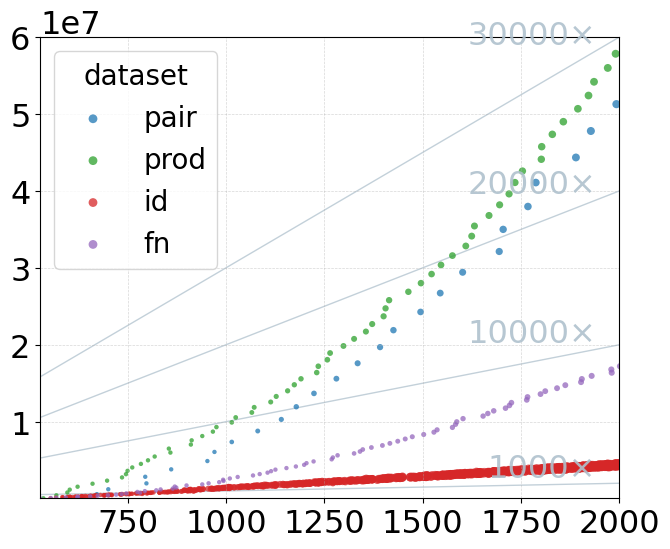

In [ ]:
import numpy as np
import matplotlib.ticker as ticker

unit = "heartbeats"

files = [
    ("bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("bench/2025_09_05_times_id_cache.ndjson",   "id"),
    ("bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
]

colors = {
    "pair": "#1f77b4",
    "prod": "#2ca02c",
    "id":   "#d62728",
    "fn":   "#9467bd",
}

ratio_lines = [1000, 1e4, 2e4, 3e4]
ratio_color = "#afc1cd"

def load_xy_size(path):
    ts, cs, sizes = [], [], []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            if hasattr(ob, "t_kernel") and hasattr(ob, "t_typecheck"):
                ts.append(ob.t_kernel)
                cs.append(ob.t_typecheck)
                sz_val = getattr(ob, "sz_val", 0)
                sz_tp  = getattr(ob, "sz_tp", 0)
                sizes.append(sz_val + sz_tp)
    return ts, cs, sizes

datasets = {}
for path, label in files:
    ts_raw, cs_raw, sz_raw = load_xy_size(path)
    if not ts_raw:
        continue
    ts_sorted, cs_sorted, sz_sorted = zip(*sorted(zip(ts_raw, cs_raw, sz_raw)))
    datasets[label] = (
        np.array(ts_sorted, dtype=float),
        np.array(cs_sorted, dtype=float),
        np.array(sz_sorted, dtype=float),
    )

if datasets:
    all_sizes = np.concatenate([v[2] for v in datasets.values()])
    high = np.percentile(all_sizes, 99) if all_sizes.size else 1.0
    high = max(high, 1.0)
    if np.all(all_sizes == 0):
        size_scale = 20.0
    else:
        target_area_at_high = 120.0
        size_scale = target_area_at_high / high

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6.8, 5.6)

for label, (tx, ty, tz) in datasets.items():
    if np.any(tz):
        tz_clamped = np.minimum(tz, np.percentile(tz, 99))
        sizes = np.maximum(tz_clamped * size_scale, 10.0)
    else:
        sizes = np.full_like(tz, 20.0)
    ax.scatter(tx, ty, s=sizes, alpha=0.75, label=label, color=colors.get(label, None), edgecolors='none')


if datasets:
    all_x = np.concatenate([v[0] for v in datasets.values()])
    all_y = np.concatenate([v[1] for v in datasets.values()])
    xmin, xmax = np.nanmin(all_x), np.nanmax(all_x)
    ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
    ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
    ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))


ax.set_xlim(xmin, 2000)
ax.set_ylim(ymin, 0.6 * 1e8)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()


for k in ratio_lines:
    xs_line = np.array([xmin, xmax])
    ys_line = k * xs_line
    ax.plot(xs_line, ys_line, linestyle='-', color=ratio_color, linewidth=1, alpha=0.75, zorder=0)

    x_tag = xmax / 1.03
    y_tag = k * x_tag
    if y_tag >= ymax:
        y_tag = ymax / 1.1
    ax.text(x_tag, y_tag, f"{k:g}×",
            color=ratio_color, fontsize=23,
            ha='right', va='bottom', alpha=0.9, rotation=0)


ax.grid(True, which='both', linestyle="--", linewidth=0.5, alpha=0.5)
legend = ax.legend(title="dataset", loc="best") #, fontsize=20, title_fontsize=20)
for handle in legend.legend_handles:
    handle.set_sizes([40])

ax.tick_params(axis='both', which='major') #, labelsize=23)

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "text.usetex": False,
    "font.size": 23,
    "pgf.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{libertine}",
        ])
})


formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0,0))
formatter.format = "%.1f"

plt.tight_layout()
# plt.show()
plt.savefig('tt.pgf', backend='pgf')

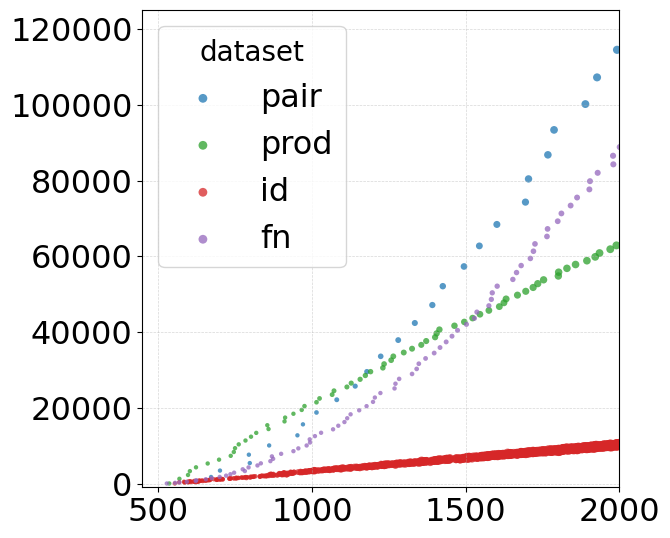

In [ ]:
unit = "heartbeats"

files = [
    ("bench/2025_09_05_times_pair_cache.ndjson", "pair"),
    ("bench/2025_09_05_times_prod_cache.ndjson", "prod"),
    ("bench/2025_09_05_times_id_cache.ndjson",   "id"),
    ("bench/2025_09_05_times_fn_cache.ndjson",   "fn"),
]

colors = {
    "pair": "#1f77b4",
    "prod": "#2ca02c",
    "id":   "#d62728",
    "fn":   "#9467bd",
}

# 等比线
ratio_lines = [1, 10, 20, 30, 40, 50, 60]
ratio_color = "#afc1cd"
use_log = False

# ========== 工具函数：读取 x, y 与 size ==========
def load_xy_size(path):
    ts, cs, sizes = [], [], []
    with open(path, 'r') as f:
        for line in f:
            ob = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
            if hasattr(ob, "t_kernel") and hasattr(ob, "sz_deep_wf_val_shared"):
                ts.append(ob.t_kernel)
                cs.append(ob.sz_deep_wf_val_shared)
                sz_val = getattr(ob, "sz_val", 0)
                sz_tp  = getattr(ob, "sz_tp", 0)
                sizes.append(sz_val + sz_tp)
    return ts, cs, sizes

datasets = {}
for path, label in files:
    ts_raw, cs_raw, sz_raw = load_xy_size(path)
    if not ts_raw:
        continue
    ts_sorted, cs_sorted, sz_sorted = zip(*sorted(zip(ts_raw, cs_raw, sz_raw)))
    datasets[label] = (
        np.array(ts_sorted, dtype=float),
        np.array(cs_sorted, dtype=float),
        np.array(sz_sorted, dtype=float),
    )

if datasets:
    all_sizes = np.concatenate([v[2] for v in datasets.values()])
    high = np.percentile(all_sizes, 99) if all_sizes.size else 1.0
    high = max(high, 1.0)
    if np.all(all_sizes == 0):
        size_scale = 20.0
    else:
        target_area_at_high = 120.0
        size_scale = target_area_at_high / high

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6.8, 5.6)

for label, (tx, ty, tz) in datasets.items():
    if np.any(tz):
        tz_clamped = np.minimum(tz, np.percentile(tz, 99))
        sizes = np.maximum(tz_clamped * size_scale, 10.0)
    else:
        sizes = np.full_like(tz, 20.0)
    ax.scatter(tx, ty, s=sizes, alpha=0.75, label=label, color=colors.get(label, None), edgecolors='none')

if use_log:
    ax.set_xscale('log')
    ax.set_yscale('log')

if datasets:
    all_x = np.concatenate([v[0] for v in datasets.values()])
    all_y = np.concatenate([v[1] for v in datasets.values()])
    xmin, xmax = np.nanmin(all_x), np.nanmax(all_x)
    ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
    if use_log:
        ax.set_xlim(xmin * 0.8, xmax * 1.25)
        ax.set_ylim(ymin * 0.8, ymax * 1.25)
    else:
        ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
        ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))


ax.set_xlim(xmin-80, 2000)
ax.set_ylim(ymin - 1000, 125000)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.grid(True, which='both', linestyle="--", linewidth=0.5, alpha=0.5)
legend = ax.legend(title="dataset", loc="best") #fontsize=23, title_fontsize=20)
for handle in legend.legend_handles:
    handle.set_sizes([40])

ax.tick_params(axis='both', which='major') #, labelsize=23)  # 设置主要刻度标签大小

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "text.usetex": False,
    "font.size": 23,
    "pgf.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{libertine}",
        ])
})


formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0,0))
formatter.format = "%.1f"

plt.tight_layout()
plt.savefig('tcs.pgf', backend='pgf')
#plt.show()